In [ ]:
# default_exp models.ph

# Piecewise Hazard Model
> How to estimate the Piecewise Hazard estimator.

In this module we assume that during a given time period the hazard is constant.

In [ ]:
# export
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.Tensor.ndim = property(lambda x: x.dim())

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
class PieceWiseHazard(nn.Module):
    """
    Piecewise Hazard where the hazard is constant between breakpoints.
    parameters:
    - breakpoints: time points where hazard would change
    - max_t: maximum point of time to plot to.
    """
    def __init__(self, breakpoints, max_t):
        super().__init__()
        self.logλ = nn.Parameter(torch.randn(len(breakpoints)+1, 1))
        self.register_buffer('breakpoints', torch.Tensor([0] + breakpoints.tolist()))
        bounded_bp = [0] + breakpoints.tolist() + [max_t]
#         self.widths = torch.Tensor(np.diff(bounded_bp).tolist())[:,None]
        self.register_buffer('widths', torch.Tensor(np.diff(bounded_bp).tolist())[:,None])
#         self.zero = torch.zeros(1,1)
        self.prepend_zero = nn.ConstantPad2d((0,0,1,0), 0)
        self.max_t = max_t
        
    def cumulative_hazard(self, t, t_section):
        """
        Integral of hazard wrt time.
        """
        λ = torch.exp(self.logλ)

        # cumulative hazard 
        cum_hazard = λ * self.widths
        cum_hazard = cum_hazard.cumsum(0)
        cum_hazard = self.prepend_zero(cum_hazard)
        cum_hazard_sec = cum_hazard[t_section]
        
        δ_t = t - self.breakpoints[t_section][:,None]
        
        return cum_hazard_sec + λ[t_section] * δ_t
        
    def forward(self, t, t_section, *args):
        return self.logλ[t_section], self.cumulative_hazard(t, t_section)
    
    def plot_survival_function(self):
        with torch.no_grad():
            # get the times and time sections for survival function
            t_query = np.arange(self.max_t+10)
            breakpoints = self.breakpoints[1:].cpu().numpy()
            t_sec_query = np.searchsorted(breakpoints, t_query)
            # convert to pytorch tensors
            t_query = torch.Tensor(t_query)[:,None]
            t_sec_query = torch.LongTensor(t_sec_query)

            # calculate cumulative hazard according to above
            cum_haz = self.cumulative_hazard(t_query, t_sec_query)
            surv_fun = torch.exp(-cum_haz)
        
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t_query, surv_fun)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.show()
        
    def plot_hazard(self):
        """
        Plot base hazard
        """
        with torch.no_grad():
            width = self.widths.squeeze()
            x = self.breakpoints.squeeze()
            λ = torch.exp(self.logλ)
            y = λ.squeeze()
        # plot
        plt.figure(figsize=(12,5))
        plt.bar(x, y, width, align='edge')
        plt.ylabel('λ')
        plt.xlabel('t')
        plt.show()

## Fitting KM Model to Rossi dataset

In [ ]:
# hide
from torchlife.data import create_db
import pandas as pd

url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/rossi.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


Create breakpoints by splitting up the time.

In [ ]:
df.rename(columns={'week':'t', 'arrest':'e'}, inplace=True)

event_times = df.loc[df['e']==1, 't'].values
breakpoints = np.percentile(event_times, [20, 40, 60, 80])
print(breakpoints)

db = create_db(df, breakpoints)

[14.6 24.  35.  43.4]


epoch,train_loss,valid_loss,time
0,104.148125,#na#,00:00
1,104.109100,#na#,00:00
2,104.009598,#na#,00:00
3,104.130783,#na#,00:00
4,104.044785,#na#,00:00
5,104.046417,#na#,00:00
6,104.023987,#na#,00:00
7,104.089973,#na#,00:00
8,104.065819,#na#,00:00
9,104.075676,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


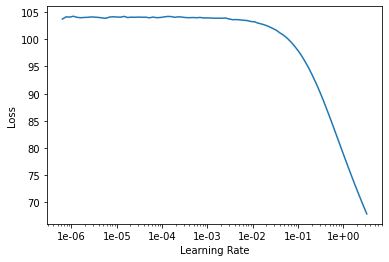

In [ ]:
from fastai.basics import Learner
from torchlife.losses import hazard_loss

model = PieceWiseHazard(breakpoints, df['t'].max())
learner = Learner(db, model, loss_func=hazard_loss)
learner.lr_find()
learner.recorder.plot()

In [ ]:
epochs = 20
learner.fit(epochs, lr=1)

epoch,train_loss,valid_loss,time
0,52.270878,8.201595,00:00
1,27.967197,2.709759,00:00
2,18.780933,2.144613,00:00
3,14.104306,2.136511,00:00
4,11.289813,2.196592,00:00
5,9.424635,2.244485,00:00
6,8.104904,2.267983,00:00
7,7.121221,2.268606,00:00
8,6.354393,2.250747,00:00
9,5.747944,2.220314,00:00


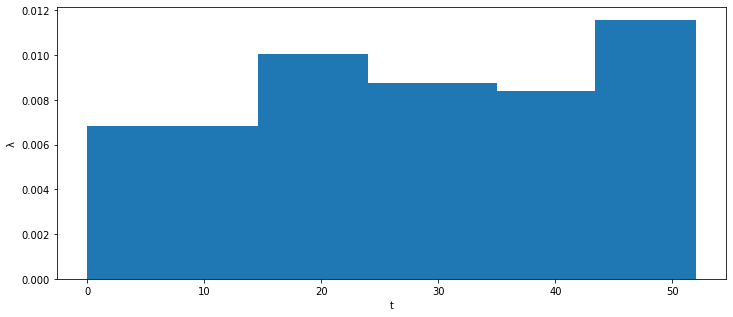

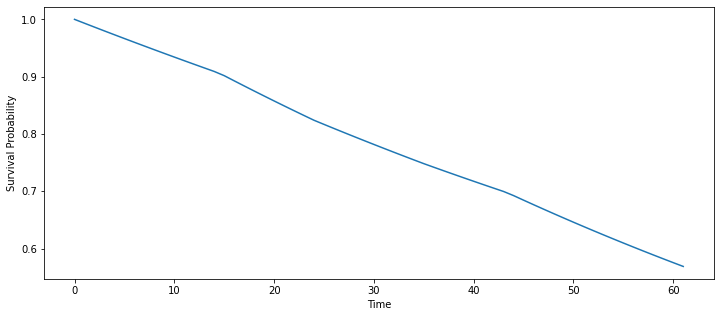

In [ ]:
learner.model.plot_hazard()
learner.model.plot_survival_function()

In [ ]:
# hide
from nbdev.export import *
notebook2script("PiecewiseHazard.ipynb")

Converted PiecewiseHazard.ipynb.
